First 5 rows of the dataset:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2016-10-15 21:32:11            False                  False   
1           1  2016-11-09 05:01:30            False                  False   
2           2  2017-06-17 05:34:27            False                  False   
3           3  2016-07-21 13:32:25             True                  False   
4           4  2012-01-15 16:32:35            False                  False   

                                         description  favourites_count  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...                 4   
1  Photographing the American West since 1980. I ...               536   
2  Scruffy looking nerf herder and @twitch broadc...              3307   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...              8433   
4               Loan coach at @mancity & Aspiring DJ                88   

   followers_count  friends_count  geo_enabled           

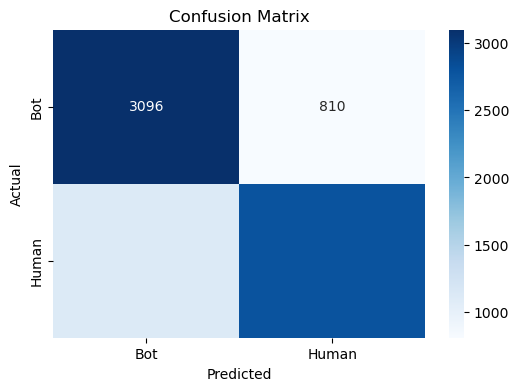

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file using pandas
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Data inspection
print("First 5 rows of the dataset:")
print(df.head())

# Handle missing values
df = df.dropna().reset_index(drop=True)

# Encode target variable
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])  # 'bot' -> 0, 'human' -> 1

# Convert boolean columns
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode categorical features
df['lang_encoded'] = le.fit_transform(df['lang'])

# Feature selection
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'description', 'id',
    'profile_background_image_url', 'profile_image_url',
    'screen_name', 'location', 'account_type', 'lang'
])

# # Define features and target
# X = df_model.drop('account_type_encoded', axis=1)
# y = df_model['account_type_encoded']

# # Addressing class imbalance in the training data
# # Separate majority and minority classes
# df_majority = df_model[df_model['account_type_encoded'] == 1]  # Human
# df_minority = df_model[df_model['account_type_encoded'] == 0]  # Bot

# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                    replace=False,            # sample without replacement
#                                    n_samples=len(df_minority),  # match minority class size
#                                    random_state=42)

# # Combine minority class with downsampled majority class
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

# # Separate features and target for balanced dataset
# X_balanced = df_balanced.drop('account_type_encoded', axis=1)
# y_balanced = df_balanced['account_type_encoded']

# # Data standardization
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_balanced)

# # Train-test split with balanced data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
# )

# oversampling instead
df_majority = df_model[df_model['account_type_encoded'] == 1]  # Human
df_minority = df_model[df_model['account_type_encoded'] == 0]  # Bot

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,              # sample with replacement
                                   n_samples=len(df_majority),  # match majority class size
                                   random_state=42)

# Combine majority class with oversampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Separate features and target for balanced dataset
X_balanced = df_balanced.drop('account_type_encoded', axis=1)
y_balanced = df_balanced['account_type_encoded']

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split with balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Initialize logistic regression model with cross-validation for regularization parameter
best_score = 0
best_C = None

# Test different values of C using cross-validation
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    # Using StratifiedKFold to maintain class balance in folds
    skf = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean CV Accuracy for C={C}: {mean_cv_score:.4f}")
    
    # Save the best C value based on mean cross-validation score
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_C = C

print(f"\nBest C found: {best_C} with CV Accuracy: {best_score:.4f}")

# Train the model with the best C
model = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bot', 'Human']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [3]:
cm

array([[3096,  810],
       [1119, 2787]])


Feature Importances:
                   Feature  Importance
7                 verified    0.931200
2         favourites_count    0.776623
6           statuses_count    0.609259
5              geo_enabled    0.582955
8   average_tweets_per_day    0.465328
0          default_profile    0.303515
4            friends_count    0.217666
9         account_age_days    0.216550
10            lang_encoded    0.130759
3          followers_count    0.030145
1    default_profile_image    0.013935


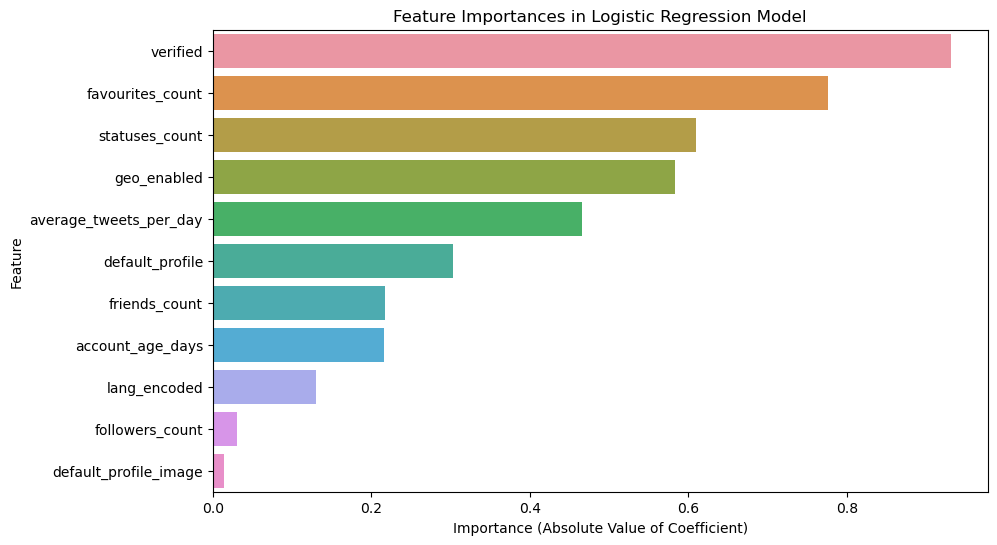

In [4]:
# Feature importance extraction and visualization
importances = np.abs(model.coef_[0])  # Extract absolute values of coefficients for feature importance
feature_names = X_balanced.columns  # Use column names from the balanced dataset

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("\nFeature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance (Absolute Value of Coefficient)')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression Model')
plt.show()


In [5]:
# Hyperparameter tuning
c_values = [0.01, 0.1, 1, 10, 100]
for c in c_values:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"C={c}: Accuracy={accuracy:.2f}")

C=0.01: Accuracy=0.75
C=0.1: Accuracy=0.75
C=1: Accuracy=0.75
C=10: Accuracy=0.75
C=100: Accuracy=0.75


In [6]:
# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]

# Examine misclassified examples
sample_indices = np.random.choice(misclassified_indices, size=5, replace=False)
for idx in sample_indices:
    actual_label = 'Bot' if y_test.iloc[idx] == 0 else 'Human'
    predicted_label = 'Bot' if y_pred[idx] == 0 else 'Human'
    print(f"Index: {idx}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Features: {X_test[idx]}")
    print("-" * 50)

Index: 4679
Actual Label: Bot
Predicted Label: Human
Features: [-0.70751414 -0.04911578 -0.30589312 -0.15343773 -0.0814537   1.09898932
 -0.26396897 -0.49343068 -0.23456452  1.08997223 -0.34663066]
--------------------------------------------------
Index: 1620
Actual Label: Human
Predicted Label: Bot
Features: [-0.70751414 -0.04911578  0.26239246 -0.15293399 -0.10182387  1.09898932
  1.45555473 -0.49343068  1.10192578  0.33104591 -0.34663066]
--------------------------------------------------
Index: 1047
Actual Label: Bot
Predicted Label: Human
Features: [-7.07514140e-01 -4.91157764e-02  6.33041742e+00 -1.51043361e-01
  5.60091358e-03 -9.09926950e-01  2.33729145e+00 -4.93430676e-01
  1.70315961e+00  5.00605720e-01 -3.46630656e-01]
--------------------------------------------------
Index: 2657
Actual Label: Bot
Predicted Label: Human
Features: [-0.70751414 -0.04911578 -0.1967492  -0.14404845 -0.10415478  1.09898932
  0.06906158  2.02662714  0.06809396 -0.17412538 -0.34663066]
----------

In [8]:
# Identify misclassified examples
misclassified = X_test[y_test != y_pred]
y_misclassified_true = y_test[y_test != y_pred]  # True labels
y_misclassified_pred = y_pred[y_test != y_pred]  # Predicted labels

# Add original features back to the misclassified examples for inspection
misclassified_df = pd.DataFrame(scaler.inverse_transform(misclassified), columns=df_model.columns[:-1])
misclassified_df['true_label'] = y_misclassified_true.values
misclassified_df['predicted_label'] = y_misclassified_pred

print("First 5 Misclassified Examples:")
print(misclassified_df.head())

First 5 Misclassified Examples:
   default_profile  default_profile_image  favourites_count  followers_count  \
0              0.0                    0.0           15186.0          24059.0   
1              0.0                    0.0           66509.0            836.0   
2              0.0                    0.0            4804.0           1071.0   
3              1.0                    0.0            3071.0            210.0   
4              0.0                    0.0           25878.0            170.0   

   friends_count  geo_enabled  statuses_count  verified  \
0            4.0          0.0         15870.0       0.0   
1          200.0          0.0         80159.0       0.0   
2            0.0          1.0         11210.0       0.0   
3         1978.0          0.0          2742.0       0.0   
4           90.0          0.0          4230.0       0.0   

   average_tweets_per_day  account_age_days  account_type_encoded  true_label  \
0                   6.788            2338.0        

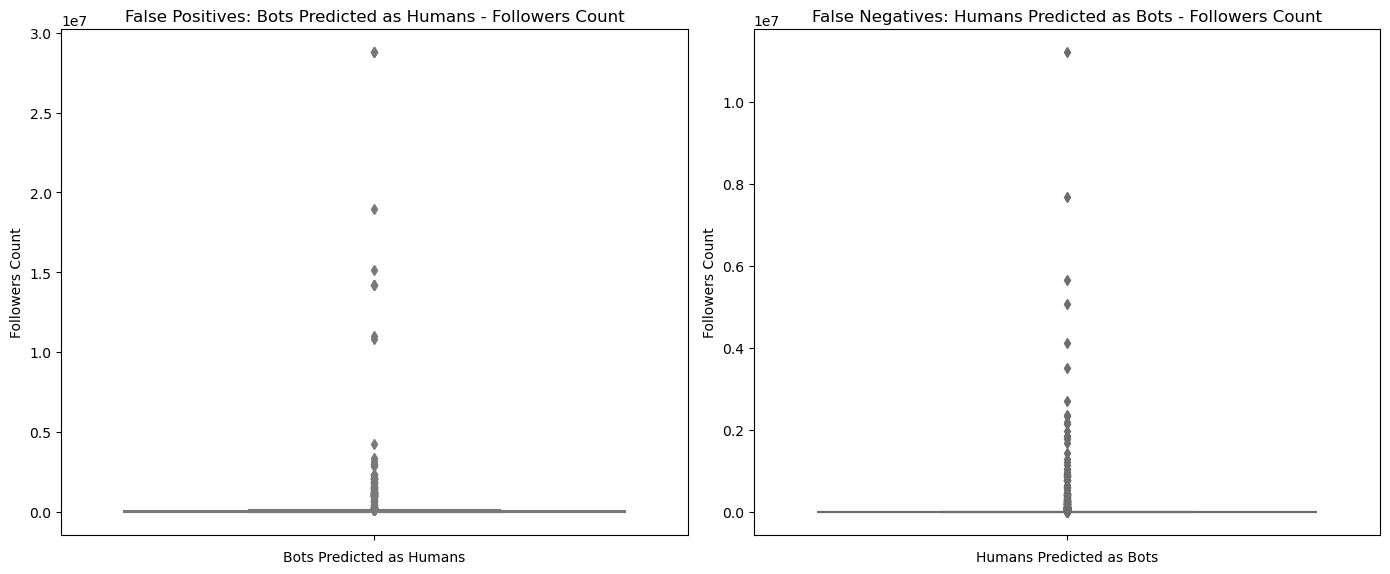

In [13]:
# Filter misclassifications by type
false_positives = misclassified_df[misclassified_df['true_label'] == 0]  # Bots misclassified as Humans
false_negatives = misclassified_df[misclassified_df['true_label'] == 1]  # Humans misclassified as Bots

# Plot followers and friends counts for each error type
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=false_positives, y='followers_count', color='lightblue')
plt.title('False Positives: Bots Predicted as Humans - Followers Count')
plt.xlabel('Bots Predicted as Humans')
plt.ylabel('Followers Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=false_negatives, y='followers_count', color='salmon')
plt.title('False Negatives: Humans Predicted as Bots - Followers Count')
plt.xlabel('Humans Predicted as Bots')
plt.ylabel('Followers Count')

plt.tight_layout()
plt.show()

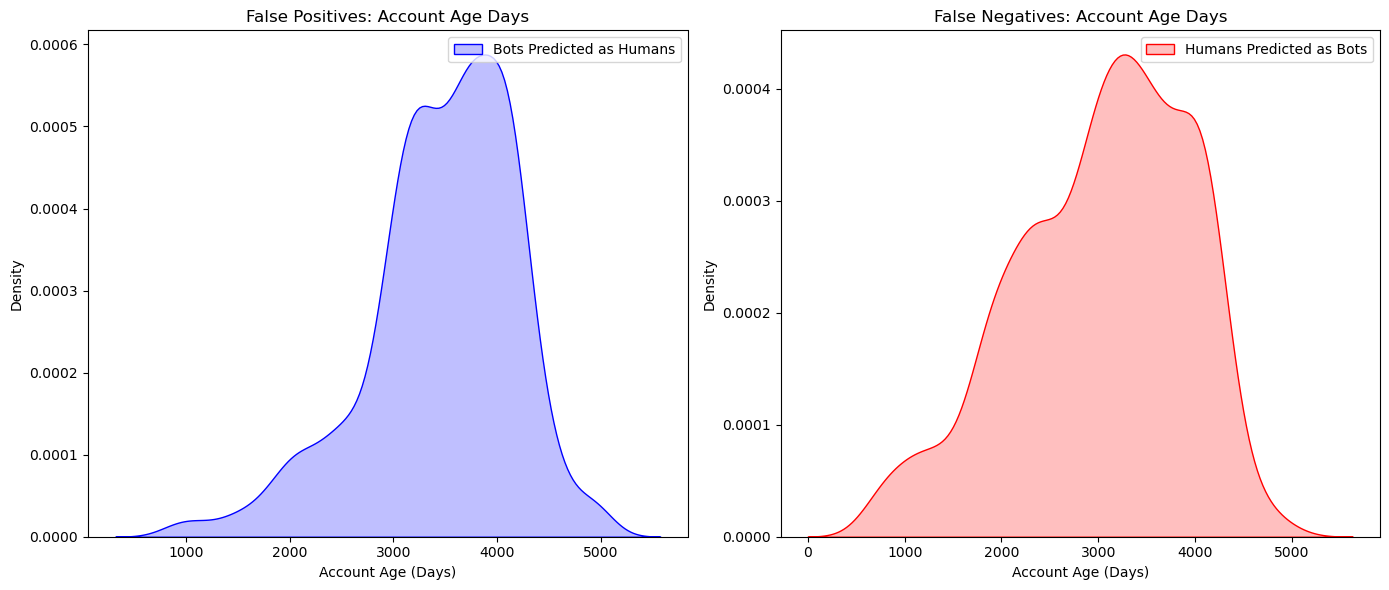

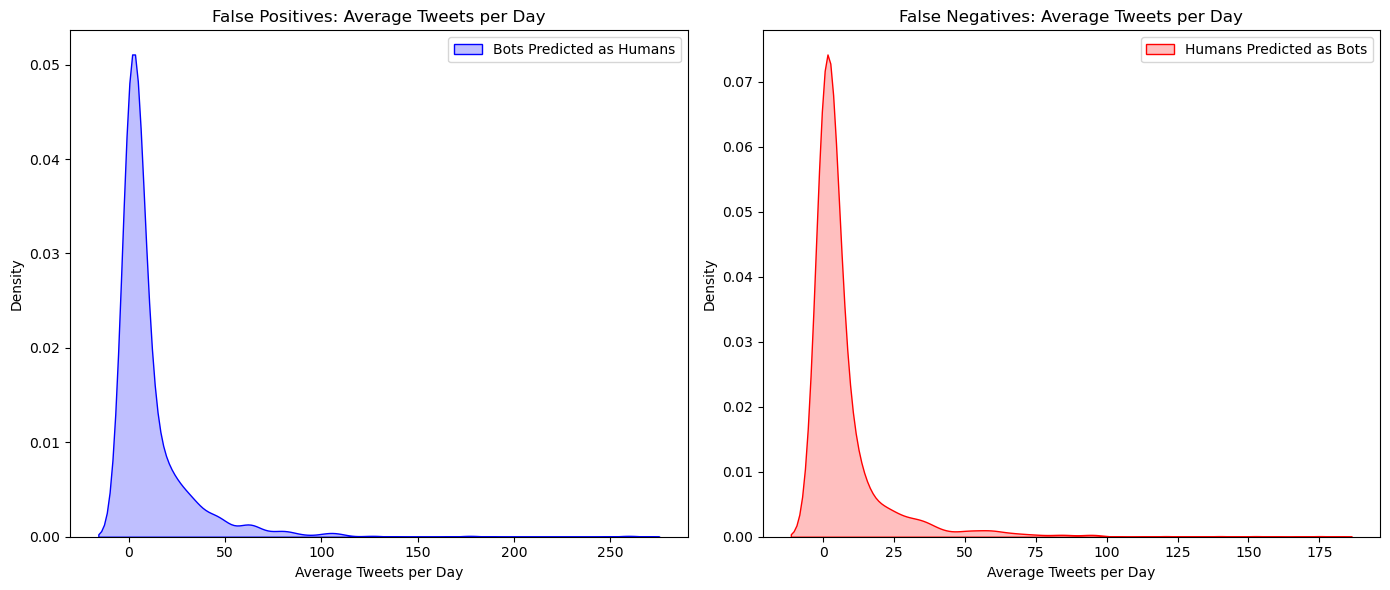

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=false_positives, x='account_age_days', fill=True, color='blue', label='Bots Predicted as Humans'
)
plt.title('False Positives: Account Age Days')
plt.xlabel('Account Age (Days)')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=false_negatives, x='account_age_days', fill=True, color='red', label='Humans Predicted as Bots'
)
plt.title('False Negatives: Account Age Days')
plt.xlabel('Account Age (Days)')
plt.legend()

plt.tight_layout()
plt.show()

# Density plots for average tweets per day
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=false_positives, x='average_tweets_per_day', fill=True, color='blue', label='Bots Predicted as Humans'
)
plt.title('False Positives: Average Tweets per Day')
plt.xlabel('Average Tweets per Day')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=false_negatives, x='average_tweets_per_day', fill=True, color='red', label='Humans Predicted as Bots'
)
plt.title('False Negatives: Average Tweets per Day')
plt.xlabel('Average Tweets per Day')
plt.legend()

plt.tight_layout()
plt.show()

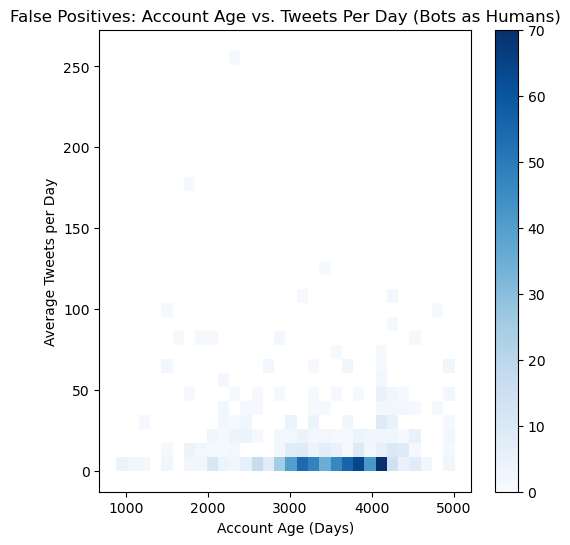

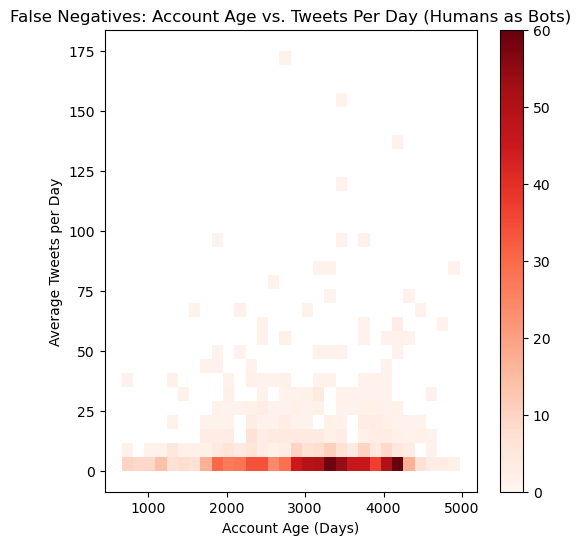

In [15]:
# False positives heatmap
plt.figure(figsize=(6, 6))
sns.histplot(
    data=false_positives, x='account_age_days', y='average_tweets_per_day',
    bins=30, cmap="Blues", cbar=True
)
plt.title('False Positives: Account Age vs. Tweets Per Day (Bots as Humans)')
plt.xlabel('Account Age (Days)')
plt.ylabel('Average Tweets per Day')
plt.show()

# False negatives heatmap
plt.figure(figsize=(6, 6))
sns.histplot(
    data=false_negatives, x='account_age_days', y='average_tweets_per_day',
    bins=30, cmap="Reds", cbar=True
)
plt.title('False Negatives: Account Age vs. Tweets Per Day (Humans as Bots)')
plt.xlabel('Account Age (Days)')
plt.ylabel('Average Tweets per Day')
plt.show()

In [17]:
# Separate correctly classified samples
correctly_classified = X_test[y_test == y_pred]
y_correct_true = y_test[y_test == y_pred]

# Convert scaled data back to original values for better interpretability
correctly_classified_df = pd.DataFrame(scaler.inverse_transform(correctly_classified), columns=df_model.columns[:-1])
correctly_classified_df['true_label'] = y_correct_true.values
correctly_classified_df['classification_status'] = 'Correct'

# Update misclassified dataframe for labeling
misclassified_df['classification_status'] = 'Misclassified'

# Combine for easier comparison in plots
comparison_df = pd.concat([correctly_classified_df, misclassified_df])

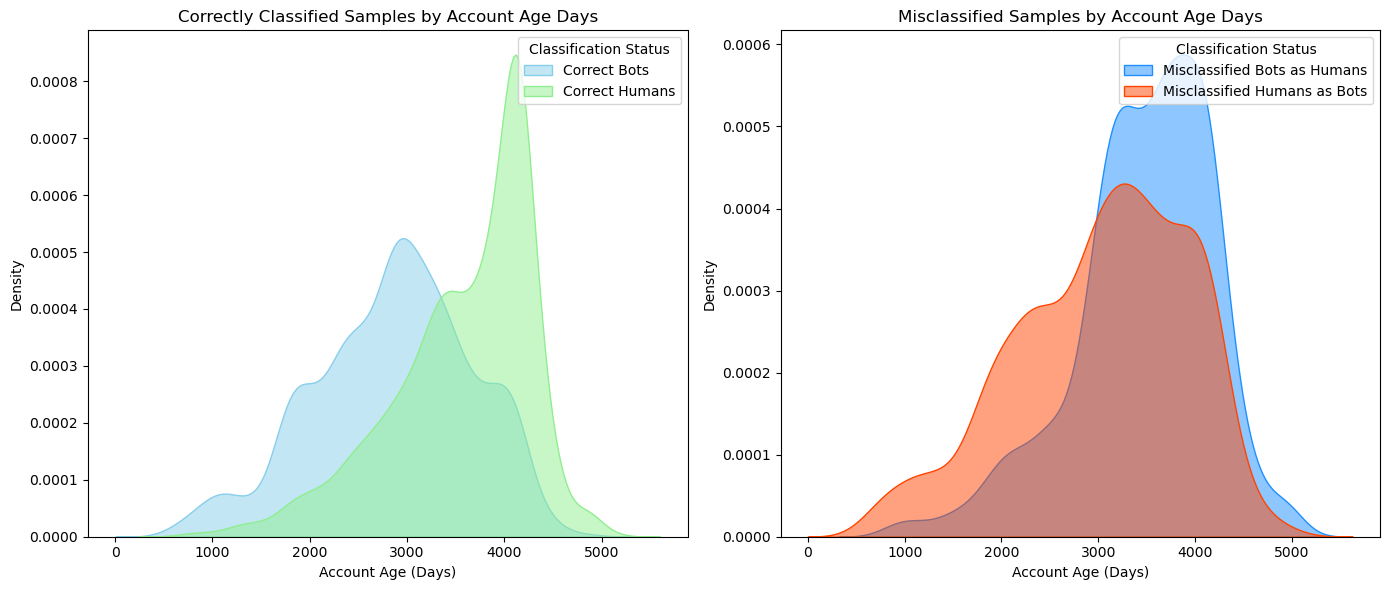

In [23]:
# Density plot for account_age_days with enriched labeling and improved clarity
plt.figure(figsize=(14, 6))

# Plot for Correctly Classified Samples
plt.subplot(1, 2, 1)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Correct') & (comparison_df['true_label'] == 0)],
    x='account_age_days', fill=True, color='skyblue', alpha=0.5, label='Correct Bots'
)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Correct') & (comparison_df['true_label'] == 1)],
    x='account_age_days', fill=True, color='lightgreen', alpha=0.5, label='Correct Humans'
)
plt.title('Correctly Classified Samples by Account Age Days')
plt.xlabel('Account Age (Days)')
plt.ylabel('Density')
plt.legend(title="Classification Status", loc='upper right')

# Plot for Misclassified Samples
plt.subplot(1, 2, 2)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 0)],
    x='account_age_days', fill=True, color='dodgerblue', alpha=0.5, label='Misclassified Bots as Humans'
)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 1)],
    x='account_age_days', fill=True, color='orangered', alpha=0.5, label='Misclassified Humans as Bots'
)
plt.title('Misclassified Samples by Account Age Days')
plt.xlabel('Account Age (Days)')
plt.ylabel('Density')
plt.legend(title="Classification Status", loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
# Filter misclassified samples into false positives and false negatives
false_positives = comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 0)]
false_negatives = comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 1)]

# Calculate misclassification rates by age range for false positives and false negatives
false_positive_stats = false_positives.groupby('age_range').size()
false_negative_stats = false_negatives.groupby('age_range').size()

# Calculate total counts in each range for normalization
total_counts = comparison_df.groupby('age_range').size()

# Calculate misclassification rates as percentages
error_stats = pd.DataFrame({
    'False Positives (%)': (false_positive_stats / total_counts * 100).fillna(0),
    'False Negatives (%)': (false_negative_stats / total_counts * 100).fillna(0),
    'Total Misclassified (%)': ((false_positive_stats + false_negative_stats) / total_counts * 100).fillna(0)
})

# Display misclassification statistics
print("Misclassification Statistics by Account Age Range and Type:")
print(error_stats)

Misclassification Statistics by Account Age Range and Type:
              False Positives (%)  False Negatives (%)  \
age_range                                                
(0, 1000]                4.040404            26.262626   
(1000, 2000]             4.027778            18.611111   
(2000, 3000]             6.021811            15.552394   
(3000, 4000]            13.918495            13.981191   
(4000, 5000]            12.130178            10.946746   
(5000, 6000]            25.000000             0.000000   

              Total Misclassified (%)  
age_range                              
(0, 1000]                   30.303030  
(1000, 2000]                22.638889  
(2000, 3000]                21.574206  
(3000, 4000]                27.899687  
(4000, 5000]                23.076923  
(5000, 6000]                25.000000  


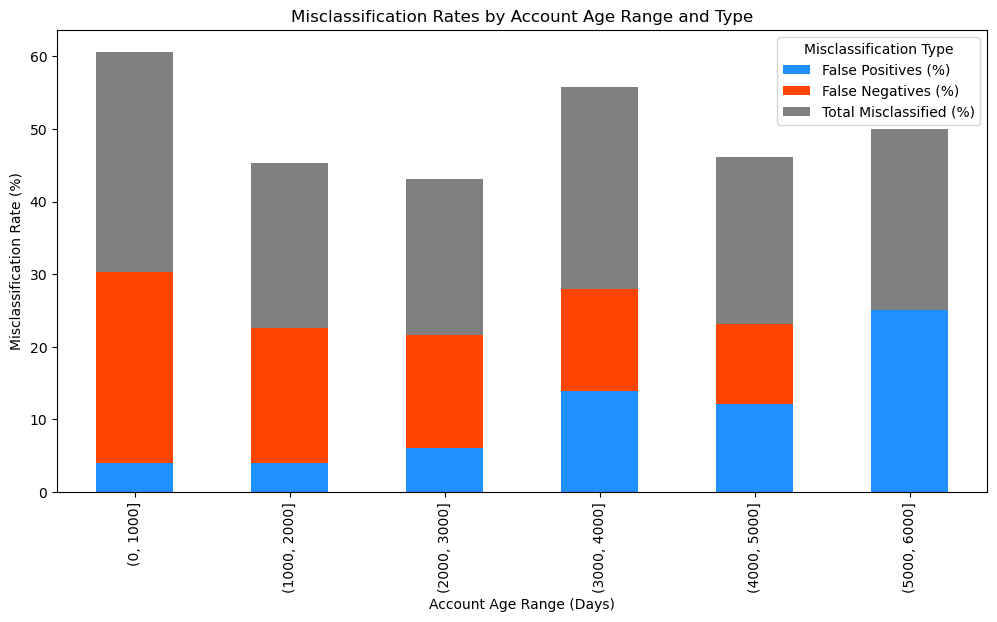

In [27]:
# Bar plot for misclassification rates by age range and type
error_stats.plot(kind='bar', stacked=True, color=['dodgerblue', 'orangered', 'grey'], figsize=(12, 6))
plt.title('Misclassification Rates by Account Age Range and Type')
plt.xlabel('Account Age Range (Days)')
plt.ylabel('Misclassification Rate (%)')
plt.legend(title='Misclassification Type')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Plot CDF for false positives and false negatives
sns.ecdfplot(data=false_positives, x='account_age_days', color='dodgerblue', label='False Positives (Bots as Humans)')
sns.ecdfplot(data=false_negatives, x='account_age_days', color='orangered', label='False Negatives (Humans as Bots)')

plt.title('Cumulative Distribution of Account Age Days by Misclassification Type')
plt.xlabel('Account Age (Days)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()